In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import scipy.stats as stats
from scipy.stats import poisson

# Set some Pandas options
pd.set_option('notebook_repr_html', False)
pd.set_option('max_columns', 30)
pd.set_option('max_rows', 20)
#max rows and columns are important not to crash the notebook

In [2]:
all_data = pd.read_excel("..//Data/traffic-collision/Collisions.xlsx", sheet_name = 'All_Collisions_1')
all_data

       OBJECTID  Shape                              ADDRESS  \
0         28948    NaN         E CONE BLVD / N O HENRY BLVD   
1         28949    NaN             N CHURCH ST / CHARLES ST   
2         28950    NaN  JOSEPH M BRYAN BLVD / NEW GARDEN RD   
3         28951    NaN              W MARKET ST / N TATE ST   
4         28952    NaN           PHILLIPS AV / N ENGLISH ST   
5         28953    NaN              SUMMIT AV / PHILLIPS AV   
6         28954    NaN       E BESSEMER AV / YANCEYVILLE ST   
7         28955    NaN      BATTLEGROUND AV / W BESSEMER AV   
8         28956    NaN             E BESSEMER AV / SYKES AV   
9         28957    NaN         E LINDSAY ST / E WENDOVER AV   
...         ...    ...                                  ...   
51994    100175    NaN          E GATE CITY BLVD / MACON ST   
51995    100164    NaN            E WENDOVER AV / ELWELL AV   
51996    100165    NaN                               I 40 W   
51997    100174    NaN          E WENDOVER AV / N CHURC

### Data Cleaning

In [3]:
all_data.isnull().sum()

OBJECTID                0
Shape               52004
ADDRESS                22
ACCIDENT_CAUSE         96
COLLISION_DESC          4
WEATHER                26
LIGHT_CONDITIONS       26
ROAD_CLASS             24
TRAFFIC_CONTROL        45
PEDESTRIAN_REL        900
                    ...  
X                       0
Y                       0
BIPED               50859
SEVERITY              132
SEVERITY_CD           132
A_INJURIES            132
B_INJURIES            132
C_INJURIES            132
CASE_NUM                0
DEPARTMENT          40778
Length: 27, dtype: int64

In [4]:
all_data.COLLISION_DESC.value_counts()

ANGLE                                                                                                                                                   11094
REAR END, SLOW OR STOP                                                                                                                                  10907
SIDESWIPE, SAME DIRECTION                                                                                                                                3925
Rear End, Slow Or Stop                                                                                                                                   2714
Angle                                                                                                                                                    2601
RAN OFF ROAD - RIGHT                                                                                                                                     2473
BACKING UP                                          

In [5]:
all_data.PEDESTRIAN_REL.value_counts()

NO        50003
YES        1074
N            20
<Null>        4
MO            1
-             1
no            1
Name: PEDESTRIAN_REL, dtype: int64

In [6]:
all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False) == False, "PEDESTRIAN_REL"] = "NO"
all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False), "PEDESTRIAN_REL"] = "YES"
all_data.PEDESTRIAN_REL.value_counts()

NO     51230
YES      774
Name: PEDESTRIAN_REL, dtype: int64

In [7]:
all_data.BIPED.value_counts()

P         921
B         210
<Null>     12
p           2
Name: BIPED, dtype: int64

In [8]:
targets = ['PEDESTRIAN', 'CYCLIST']
#all_data.loc[all_data["COLLISION_DESC"].apply(lambda sentence: any(word in sentence for word in targets)) == False, 'BIPED'] = 'N'
all_data.loc[(~all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False)) &
             (~all_data["COLLISION_DESC"].str.contains("CYCLIST", na=False)), 'BIPED'] = 'M'
all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False), 'BIPED'] = 'P'
all_data.loc[all_data["COLLISION_DESC"].str.contains("CYCLIST", na=False), 'BIPED'] = 'B'
#all_all_data.loc[all_data["COLLISION_DESC"].str.contains("PEDESTRIAN", na=False) == False, "PEDESTRIAN_REL"] = "NO"data.loc[all_data["COLLISION_DESC"].str.contains("CYCLIST", na=False), "PE_CY_MO"] = "CY"
all_data.BIPED.value_counts()

M    51111
P      774
B      119
Name: BIPED, dtype: int64

In [9]:
all_data.LIGHT_CONDITIONS.value_counts()

DAYLIGHT                                                29937
Daylight                                                 6806
DARK-LIGHTED ROADWAY                                     6299
DARK - LIGHTED ROADWAY                                   2370
Dark - Lighted Roadway                                   2069
DARK-ROADWAY NOT LIGHTED                                 1181
DUSK                                                     1123
DARK - ROADWAY NOT LIGHTED                                494
Dark - Roadway Not Lighted                                486
DAWN                                                      403
                                                        ...  
OTHER*\r                                                    1
BLOWING SAND, DIRT, SNOW                                    1
DARK ROADWAY-NOT LIGHTED                                    1
DARK - LIGHTED ROADWAR                                      1
DARK UNKNOWN LIGHTING                                       1
DARK - U

In [10]:
all_data.LIGHT_CONDITIONS.value_counts()

DAYLIGHT                                                29937
Daylight                                                 6806
DARK-LIGHTED ROADWAY                                     6299
DARK - LIGHTED ROADWAY                                   2370
Dark - Lighted Roadway                                   2069
DARK-ROADWAY NOT LIGHTED                                 1181
DUSK                                                     1123
DARK - ROADWAY NOT LIGHTED                                494
Dark - Roadway Not Lighted                                486
DAWN                                                      403
                                                        ...  
OTHER*\r                                                    1
BLOWING SAND, DIRT, SNOW                                    1
DARK ROADWAY-NOT LIGHTED                                    1
DARK - LIGHTED ROADWAR                                      1
DARK UNKNOWN LIGHTING                                       1
DARK - U

In [11]:
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Daylight', 'DAYLGHT']), 'LIGHT_CONDITIONS'] = 'DAYLIGHT'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['DARK - LIGHTED ROADWAY', 'Dark - Lighted Roadway', 
                                               'DARK-LIGHTED ORADWAY', 'DARL-LIGHTED ROADWAY', 'DARK - LIGHTED ROADWAY\r',
                                               'DARK - LIGHTED ROADAY', 'DARK - LIGHTED ROADWAR',
                                               'DARK - LIGHT ROADWAY', 'DARK - LIGHTED WAY',
                                               'DARK LIGHTED ROADWAY', 'DARK- LIGHTED ROADWAY']),'LIGHT_CONDITIONS'] = 'DARK-LIGHTED ROADWAY'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Dark - Roadway Not Lighted', 'DARK - ROADWAY NOT LIGHTED\r', 
                                               'DARK-RAODWAY NOT LIGHTED', 'DARK-ROADWAY NOT LIGHTEDDARK - ROADWAY NOT LIGHTED\r',
                                               'DARK-ROADWAY NOT LIGHTED', 'DARK ROADWAY NOT LIGHTED',
                                               'DARK ROADWAY-NOT LIGHTED']),
            'LIGHT_CONDITIONS'] = 'DARK - ROADWAY NOT LIGHTED'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['DARK - UNKNOWN LIGHTING', 'DARK UNKNOWN LIGHTING', 
                                               'DARK - UNKNOWN LIGHTING\r', 'Dark - Unknown Lighting']), 
            'LIGHT_CONDITIONS'] = 'DARK-UNKNOWN LIGHTING'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Dusk']), 'LIGHT_CONDITIONS'] = 'DUSK'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Dawn']), 'LIGHT_CONDITIONS'] = 'DAWN'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['Unknown']), 'LIGHT_CONDITIONS'] = 'UNKNOWN'
all_data.loc[all_data['LIGHT_CONDITIONS'].isin(['OTHER*', 'Other', 'OTHER*\r']), 'LIGHT_CONDITIONS'] = 'OTHER'

all_data.LIGHT_CONDITIONS.value_counts()

DAYLIGHT                      36744
DARK-LIGHTED ROADWAY          10773
DARK - ROADWAY NOT LIGHTED     2172
DUSK                           1387
DAWN                            523
UNKNOWN                         194
DARK-UNKNOWN LIGHTING           154
OTHER                            23
CLOUDY                            4
RAIN                              1
BLOWING SAND, DIRT, SNOW          1
SNOW                              1
SEVERE CROSSWINDS                 1
Name: LIGHT_CONDITIONS, dtype: int64

In [12]:
all_data.WEATHER.value_counts()

CLEAR                                 31066
Clear                                  6375
CLOUDY                                 6122
RAIN                                   4484
Cloudy                                 1364
Rain                                   1291
SNOW                                    484
Snow                                    197
SLEET,HAIL,FREEZING RAIN/DRIZZLE        187
SLEET, HAIL, FREEZING RAIN/DRIZZLE      160
                                      ...  
RAIN/ SEVERE CROSSWINDS                   1
RAIN\r                                    1
-                                         1
CLOUDLY / CLEAR                           1
SLEET. HAIL. FREEZING RAIN/DRIZZLE        1
RAIN/ SNOW                                1
OTHER*\r                                  1
FOG, SMOG, SMOKE\r\n\r                    1
CLOUDY / RAIN                             1
CEAR                                      1
Name: WEATHER, Length: 34, dtype: int64

In [13]:
all_data.loc[all_data['WEATHER'].isin(['Clear', 'CEAR', 'CLEAR\nCLEAR\nCLEAR\nCLEAR']), 'WEATHER'] = 'CLEAR'
all_data.loc[all_data['WEATHER'].isin(['Cloudy']), 'WEATHER'] = 'CLOUDY'
all_data.loc[all_data['WEATHER'].isin(['Rain', 'RAIN\r']), 'WEATHER'] = 'RAIN'
all_data.loc[all_data['WEATHER'].isin(['Snow', 'SNOW\r']), 'WEATHER'] = 'SNOW'
all_data.loc[all_data['WEATHER'].isin(['SLEET, HAIL, FREEZING RAIN/DRIZZLE',
                                      'SLEET. HAIL. FREEZING RAIN/DRIZZLE',
                                      'Sleet, Hail, Freezing Rain/Drizzle']), 'WEATHER'] = 'SLEET,HAIL,FREEZING RAIN/DRIZZLE'
all_data.loc[all_data['WEATHER'].isin(['FOG,SMOG,SMOKE', 'Fog, Smog, Smoke'
                                       , 'FOG, SMOG, SMOKE\r\n\r']), 'WEATHER'] = 'FOG, SMOG, SMOKE'
all_data.loc[all_data['WEATHER'].isin(['BLOWING SAND,DIRT,SNOW', 'Blowing Sand, Dirt, Snow']), 'WEATHER'] = 'BLOWING SAND, DIRT, SNOW'
all_data.loc[all_data['WEATHER'].isin(['OTHER*\r', 'Other', 'OTHER*']), 'WEATHER'] = 'OTHER'
all_data.loc[all_data['WEATHER'].isin(['CLOUDY / RAIN', 'RAIN/CLOUDY\nRAIN/CLOUDY']), 'WEATHER'] = 'RAIN / CLOUDY'
all_data.loc[all_data['WEATHER'].isin(['-']), 'WEATHER'] = 'UNKNOWN'
all_data.WEATHER.value_counts()

CLEAR                               37443
CLOUDY                               7486
RAIN                                 5776
SNOW                                  683
SLEET,HAIL,FREEZING RAIN/DRIZZLE      403
FOG, SMOG, SMOKE                      117
OTHER                                  51
BLOWING SAND, DIRT, SNOW                6
RAIN / CLOUDY                           6
SEVERE CROSSWINDS                       3
RAIN/ SNOW                              1
UNKNOWN                                 1
CLOUDLY / CLEAR                         1
RAIN/ SEVERE CROSSWINDS                 1
Name: WEATHER, dtype: int64

In [14]:
all_data.TRAFFIC_CONTROL.value_counts()

NO CONTROL PRESENT                       26098
STOP AND GO SIGNAL                       10645
No Control Present                        5225
STOP SIGN                                 3760
Stop And Go Signal                        2936
Stop Sign                                 1005
---                                        553
FLASHING STOP AND GO SIGNAL                514
YIELD SIGN                                 467
Flashing Stop And Go Signal                146
                                         ...  
STOP AND GO SGNAL                            1
NO COLTROL PRESENT                           1
CONTROL NOT PRESENT                          1
NO CONTROL PRESEMT                           1
NO CONROL PRESENT                            1
Rr Flasher                                   1
STOP AND GO  SIGNAL                          1
DOUBLE YELLOW LINE, NO PASSING ZONE\r        1
NO CONTRL PRESENT                            1
NO CNTROL PRESENT                            1
Name: TRAFFIC

In [15]:
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Stop Sign']), 'TRAFFIC_CONTROL'] = 'STOP SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['No Control Present', 'NO CNTROL PRESENT', 'NO OCNTROL PRESENT',
                                               'NO CONROL PRESENT', 'NO CONTRL PRESENT', 'CONTROL NOT PRESENT',
                                              'NO CONTROL PRESEMT', 'NO COLTROL PRESENT', 'NO CONTROL PRSENT',
                                              'NO CONTROL PRSSENT', 'NO CONTOL PRESENT', 'NONE']), 
             'TRAFFIC_CONTROL'] = 'NO CONTROL PRESENT'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Stop And Go Signal', 'STOP AND GO SGNAL',
                                              'STOP AND GO  SIGNAL']), 'TRAFFIC_CONTROL'] = 'STOP AND GO SIGNAL'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Yield Sign']), 'TRAFFIC_CONTROL'] = 'YIELD SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Flashing Stop And Go Signal']), 
             'TRAFFIC_CONTROL'] = 'FLASHING STOP AND GO SIGNAL'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Flashing Signal With Stop Sign']), 
             'TRAFFIC_CONTROL'] = 'FLASHING SIGNAL WITH STOP SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Rr Flasher']), 'TRAFFIC_CONTROL'] = 'RR FLASHER'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['OTHER*', 'Other']), 'TRAFFIC_CONTROL'] = 'OTHER'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['School Zone Signs']), 'TRAFFIC_CONTROL'] = 'SCHOOL ZONE SIGNS'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Flashing Signal Without Stop Sign', 'FLASHING SIGNAL WITHOUT STOP SIGN\r']), 
             'TRAFFIC_CONTROL'] = 'FLASHING SIGNAL WITHOUT STOP SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Warning Sign']), 'TRAFFIC_CONTROL'] = 'WARNING SIGN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Human Control']), 'TRAFFIC_CONTROL'] = 'HUMAN CONTROL'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['---', '--']), 'TRAFFIC_CONTROL'] = 'UNKNOWN'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Rr Gate And Flasher']), 'TRAFFIC_CONTROL'] = 'RR GATE AND FLASHER'
all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['Double Yellow Line, No Passing Zone', 
                                               'DOUBLE YELLOW LINE, NO PASSING ZONE\r']),
             'TRAFFIC_CONTROL'] = 'DOUBLE YELLOW LINE, NO PASSING ZONE'
#all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['STOP AND GO SIGNAL']), 'TRAFFIC_CONTROL'] = 'STOP SIGN'
#all_data.loc[all_data['TRAFFIC_CONTROL'].isin(['FLASHING STOP AND GO SIGNAL']), 
#             'TRAFFIC_CONTROL'] = 'FLASHING SIGNAL WITH STOP SIGN'
all_data.TRAFFIC_CONTROL.value_counts()

NO CONTROL PRESENT                     31339
STOP AND GO SIGNAL                     13583
STOP SIGN                               4765
FLASHING STOP AND GO SIGNAL              660
YIELD SIGN                               594
UNKNOWN                                  554
OTHER                                    111
DOUBLE YELLOW LINE, NO PASSING ZONE       99
WARNING SIGN                              85
FLASHING SIGNAL WITH STOP SIGN            54
HUMAN CONTROL                             39
RR GATE AND FLASHER                       34
FLASHING SIGNAL WITHOUT STOP SIGN         25
SCHOOL ZONE SIGNS                          7
RR FLASHER                                 7
RR CROSSBUCKS ONLY                         3
Name: TRAFFIC_CONTROL, dtype: int64

In [16]:
all_data.HIT_RUN.value_counts()

NO     23087
N      13972
No      4621
Y       2221
YES     2150
Yes     1092
Name: HIT_RUN, dtype: int64

In [17]:
all_data.loc[all_data['HIT_RUN'].isin(['N', 'No']), 'HIT_RUN'] = 'NO'
all_data.loc[all_data['HIT_RUN'].isin(['Y', 'Yes']), 'HIT_RUN'] = 'NO'
all_data.HIT_RUN.value_counts()

NO     44993
YES     2150
Name: HIT_RUN, dtype: int64

In [18]:
all_data.SEVERITY.value_counts()

O No Injury                          31884
C Type Injury (Possible)             16286
B Type Injury (Evident)               2052
Unknown                                800
B Type Injury (Suspected Minor)        671
A Type Injury (Disabling)              128
A Type Injury (Suspected Serious)       49
UNKNOWN                                  1
C Type Injury (Possible)\r               1
Name: SEVERITY, dtype: int64

In [19]:
all_data.loc[all_data['SEVERITY'].isin(['C Type Injury (Possible)\r']), 'SEVERITY'] = 'C Type Injury (Possible)'
all_data.loc[all_data['SEVERITY'].isin(['Unknown']), 'SEVERITY'] = 'UNKNOWN'
all_data.SEVERITY.value_counts()

O No Injury                          31884
C Type Injury (Possible)             16287
B Type Injury (Evident)               2052
UNKNOWN                                801
B Type Injury (Suspected Minor)        671
A Type Injury (Disabling)              128
A Type Injury (Suspected Serious)       49
Name: SEVERITY, dtype: int64

In [20]:
all_data.ACCIDENT_DATE.value_counts()
#all_data['TIME'] = all_data.ACCIDENT_DATE.dt.time
#time is not available in this location for fatalities data
all_data['CASE_NUM'] = all_data.CASE_NUM.astype(str)
all_data['DATE'] = pd.to_datetime(all_data.CASE_NUM.str[:8])
all_data['YEAR'] = all_data.DATE.dt.year
all_data['MONTH'] = all_data.DATE.dt.month
all_data['DAY'] = all_data.DATE.dt.day_name()

all_data.DAY.value_counts()

Friday       8958
Wednesday    7868
Thursday     7821
Tuesday      7703
Monday       7607
Saturday     6758
Sunday       5289
Name: DAY, dtype: int64

In [21]:
ped_data = all_data[all_data.BIPED == 'P']
cyc_data = all_data[all_data.BIPED == 'B']
motor_data = all_data[all_data.BIPED == 'M']

### Analysis

In [22]:
df=all_data.groupby(['BIPED','YEAR']).OBJECTID.count().to_frame(name='COUNT').reset_index()
type(df)

pandas.core.frame.DataFrame

In [23]:
df

   BIPED  YEAR  COUNT
0      B  2014     27
1      B  2015     38
2      B  2016     19
3      B  2017     26
4      B  2018      9
5      M  2014   8706
6      M  2015   9740
7      M  2016  10700
8      M  2017  10873
9      M  2018  11092
10     P  2014    163
11     P  2015    171
12     P  2016    140
13     P  2017    145
14     P  2018    155

In [24]:
list(df)

['BIPED', 'YEAR', 'COUNT']

Text(0,0.5,'Collisions')

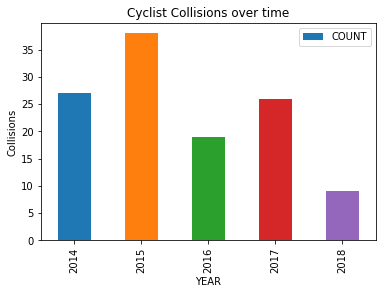

In [25]:
df[df.BIPED == 'B'].plot.bar(x='YEAR', y='COUNT')
plt.title('Cyclist Collisions over time')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

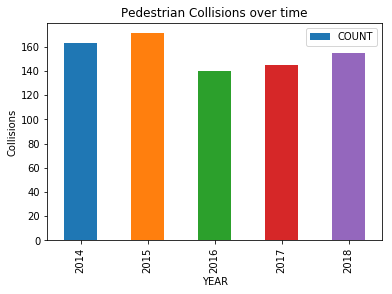

In [26]:
df[df.BIPED == 'P'].plot.bar(x='YEAR', y='COUNT')
plt.title('Pedestrian Collisions over time')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

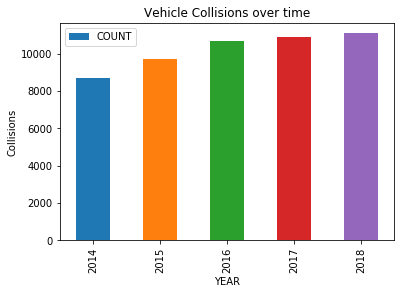

In [27]:
df[df.BIPED == 'M'].plot.bar(x='YEAR', y='COUNT')
plt.title('Vehicle Collisions over time')
plt.ylabel('Collisions')

In [28]:
df_p = df.pivot(index='BIPED', columns='YEAR')
df_p

      COUNT                           
YEAR   2014  2015   2016   2017   2018
BIPED                                 
B        27    38     19     26      9
M      8706  9740  10700  10873  11092
P       163   171    140    145    155

In [29]:
stats.chi2_contingency(df_p)


(41.88051017263556,
 1.4259898921988424e-06,
 8,
 array([[   20.35658795,    22.7661526 ,    24.84849242,    25.27182524,
            25.75694177],
        [ 8743.24005846,  9778.15819937, 10672.53190139, 10854.35512653,
         11062.71471425],
        [  132.40335359,   148.07564803,   161.61960618,   164.37304823,
           167.52834397]]))

##### Weather

In [30]:
df1=all_data.groupby(['BIPED','WEATHER']).OBJECTID.count().to_frame(name='COUNT').reset_index()
df1

   BIPED                           WEATHER  COUNT
0      B                             CLEAR     97
1      B                            CLOUDY     14
2      B                              RAIN      8
3      M          BLOWING SAND, DIRT, SNOW      6
4      M                             CLEAR  36757
5      M                   CLOUDLY / CLEAR      1
6      M                            CLOUDY   7372
7      M                  FOG, SMOG, SMOKE    117
8      M                             OTHER     50
9      M                              RAIN   5688
..   ...                               ...    ...
13     M  SLEET,HAIL,FREEZING RAIN/DRIZZLE    401
14     M                              SNOW    682
15     M                           UNKNOWN      1
16     P                             CLEAR    589
17     P                            CLOUDY    100
18     P                             OTHER      1
19     P                              RAIN     80
20     P           RAIN/ SEVERE CROSSWINDS      1


Text(0,0.5,'Collisions')

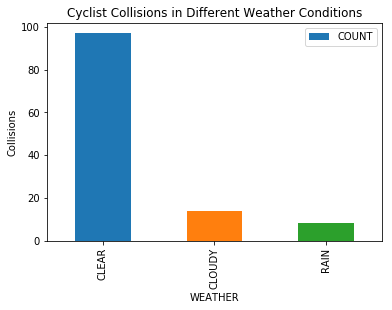

In [31]:
df1[df1.BIPED == 'B'].plot.bar(x='WEATHER', y='COUNT')
plt.title('Cyclist Collisions in Different Weather Conditions')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

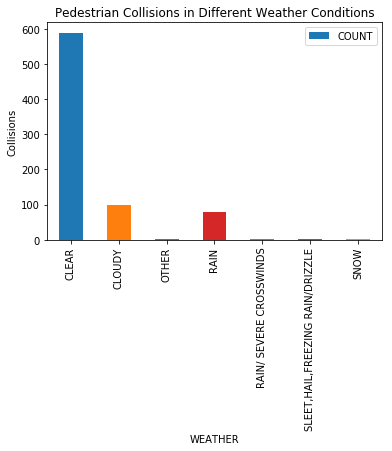

In [32]:
df1[df1.BIPED == 'P'].plot.bar(x='WEATHER', y='COUNT')
plt.title('Pedestrian Collisions in Different Weather Conditions')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

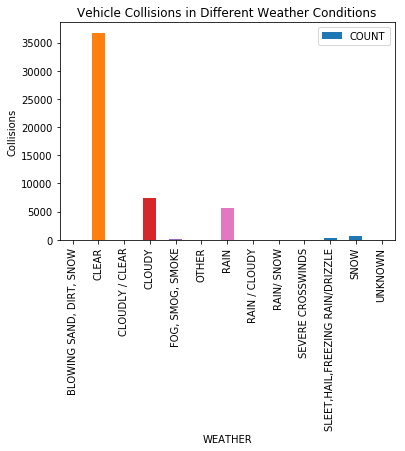

In [33]:
df1[df1.BIPED == 'M'].plot.bar(x='WEATHER', y='COUNT')
plt.title('Vehicle Collisions in Different Weather Conditions')
plt.ylabel('Collisions')

In [34]:
df1_p = df1.pivot(index='BIPED', columns='WEATHER')
df1_p=df1_p.fillna(0)
df1_p

                           COUNT                                   \
WEATHER BLOWING SAND, DIRT, SNOW    CLEAR CLOUDLY / CLEAR  CLOUDY   
BIPED                                                               
B                            0.0     97.0             0.0    14.0   
M                            6.0  36757.0             1.0  7372.0   
P                            0.0    589.0             0.0   100.0   

                                                                              \
WEATHER FOG, SMOG, SMOKE OTHER    RAIN RAIN / CLOUDY RAIN/ SEVERE CROSSWINDS   
BIPED                                                                          
B                    0.0   0.0     8.0           0.0                     0.0   
M                  117.0  50.0  5688.0           6.0                     0.0   
P                    0.0   1.0    80.0           0.0                     1.0   

                                                                              \
WEATHER RAIN/ SNOW SEVER

In [35]:
stats.chi2_contingency(df1_p)

(89.96004721114367,
 5.645092081967981e-09,
 26,
 array([[1.37365809e-02, 8.57231329e+01, 2.28943014e-03, 1.71386741e+01,
         2.67863327e-01, 1.16760937e-01, 1.32237485e+01, 1.37365809e-02,
         2.28943014e-03, 2.28943014e-03, 6.86829043e-03, 9.22640348e-01,
         1.56368079e+00, 2.28943014e-03],
        [5.89691793e+00, 3.67997163e+04, 9.82819654e-01, 7.35738793e+03,
         1.14989900e+02, 5.01238024e+01, 5.67676632e+03, 5.89691793e+00,
         9.82819654e-01, 9.82819654e-01, 2.94845896e+00, 3.96076321e+02,
         6.71265824e+02, 9.82819654e-01],
        [8.93454923e-02, 5.57560545e+02, 1.48909154e-02, 1.11473393e+02,
         1.74223710e+00, 7.59436685e-01, 8.60099273e+01, 8.93454923e-02,
         1.48909154e-02, 1.48909154e-02, 4.46727462e-02, 6.00103890e+00,
         1.01704952e+01, 1.48909154e-02]]))

In [36]:
df11 = df1[df1['WEATHER'].isin(['RAIN', 'CLOUDY', 'CLEAR'])]
df11_p = df11.pivot(index='BIPED', columns='WEATHER')
stats.chi2_contingency(df11_p)

(7.103750029797511,
 0.13050603923391968,
 4,
 array([[8.78752983e+01, 1.75689577e+01, 1.35557440e+01],
        [3.67872583e+04, 7.35489719e+03, 5.67484453e+03],
        [5.67866423e+02, 1.13533853e+02, 8.75997239e+01]]))

##### Light Condition

In [37]:
df2=all_data.groupby(['BIPED','LIGHT_CONDITIONS']).OBJECTID.count().to_frame(name='COUNT').reset_index()
df2

   BIPED            LIGHT_CONDITIONS  COUNT
0      B  DARK - ROADWAY NOT LIGHTED      7
1      B        DARK-LIGHTED ROADWAY     28
2      B                        DAWN      2
3      B                    DAYLIGHT     80
4      B                        DUSK      2
5      M    BLOWING SAND, DIRT, SNOW      1
6      M                      CLOUDY      4
7      M  DARK - ROADWAY NOT LIGHTED   2098
8      M        DARK-LIGHTED ROADWAY  10488
9      M       DARK-UNKNOWN LIGHTING    148
..   ...                         ...    ...
16     M                        SNOW      1
17     M                     UNKNOWN    193
18     P  DARK - ROADWAY NOT LIGHTED     67
19     P        DARK-LIGHTED ROADWAY    257
20     P       DARK-UNKNOWN LIGHTING      6
21     P                        DAWN     11
22     P                    DAYLIGHT    409
23     P                        DUSK     19
24     P                       OTHER      4
25     P                     UNKNOWN      1

[26 rows x 3 columns]

Text(0,0.5,'Collisions')

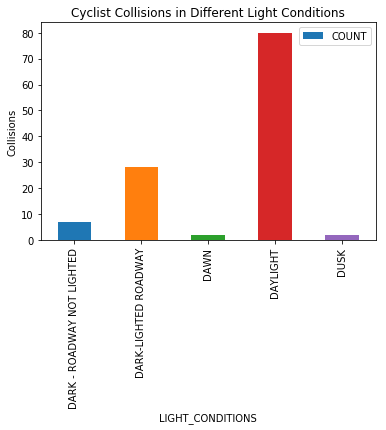

In [38]:
df2[df2.BIPED == 'B'].plot.bar(x='LIGHT_CONDITIONS', y='COUNT')
plt.title('Cyclist Collisions in Different Light Conditions')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

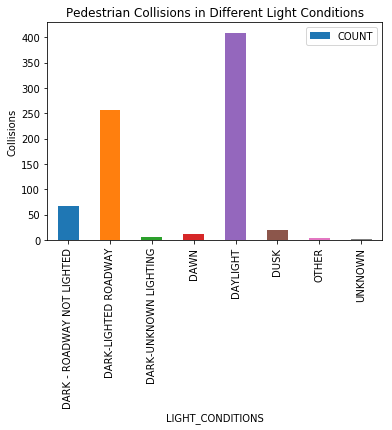

In [39]:
df2[df2.BIPED == 'P'].plot.bar(x='LIGHT_CONDITIONS', y='COUNT')
plt.title('Pedestrian Collisions in Different Light Conditions')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

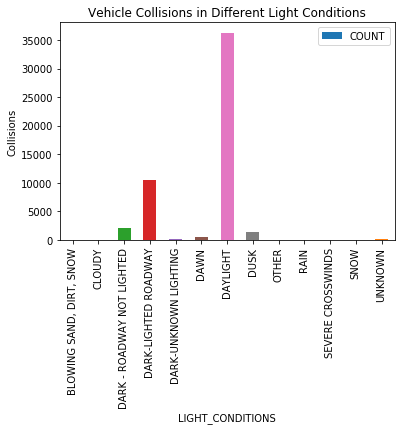

In [40]:
df2[df2.BIPED == 'M'].plot.bar(x='LIGHT_CONDITIONS', y='COUNT')
plt.title('Vehicle Collisions in Different Light Conditions')
plt.ylabel('Collisions')

In [41]:
df2_p = df2.pivot(index='BIPED', columns='LIGHT_CONDITIONS')
df2_p=df2_p.fillna(0)
df1_p

                           COUNT                                   \
WEATHER BLOWING SAND, DIRT, SNOW    CLEAR CLOUDLY / CLEAR  CLOUDY   
BIPED                                                               
B                            0.0     97.0             0.0    14.0   
M                            6.0  36757.0             1.0  7372.0   
P                            0.0    589.0             0.0   100.0   

                                                                              \
WEATHER FOG, SMOG, SMOKE OTHER    RAIN RAIN / CLOUDY RAIN/ SEVERE CROSSWINDS   
BIPED                                                                          
B                    0.0   0.0     8.0           0.0                     0.0   
M                  117.0  50.0  5688.0           6.0                     0.0   
P                    0.0   1.0    80.0           0.0                     1.0   

                                                                              \
WEATHER RAIN/ SNOW SEVER

In [42]:
stats.chi2_contingency(df2_p)

(184.19837073263918,
 1.1535142518731959e-26,
 24,
 array([[2.28943014e-03, 9.15772057e-03, 4.97264227e+00, 2.46640309e+01,
         3.52572242e-01, 1.19737197e+00, 8.41228212e+01, 3.17543961e+00,
         5.26568933e-02, 2.28943014e-03, 2.28943014e-03, 2.28943014e-03,
         4.44149448e-01],
        [9.82819654e-01, 3.93127862e+00, 2.13468429e+03, 1.05879161e+04,
         1.51354227e+02, 5.14014679e+02, 3.61127254e+04, 1.36317086e+03,
         2.26048521e+01, 9.82819654e-01, 9.82819654e-01, 9.82819654e-01,
         1.90667013e+02],
        [1.48909154e-02, 5.95636615e-02, 3.23430682e+01, 1.60419831e+02,
         2.29320097e+00, 7.78794875e+00, 5.47151795e+02, 2.06536996e+01,
         3.42491054e-01, 1.48909154e-02, 1.48909154e-02, 1.48909154e-02,
         2.88883759e+00]]))

In [43]:
df21 = df2[df2['LIGHT_CONDITIONS'].isin(['DAYLIGHT', 'DARK-LIGHTED ROADWAY', 'DARK - ROADWAY NOT LIGHTED',
                                        'DAWN', 'DUSK'])]
df21_p = df21.pivot(index='BIPED', columns='LIGHT_CONDITIONS')
stats.chi2_contingency(df21_p)

(137.10716601258463,
 9.476244819333507e-26,
 8,
 array([[5.00916684e+00, 2.48451908e+01, 1.20616679e+00, 8.47407120e+01,
         3.19876354e+00],
        [2.13487323e+03, 1.05888533e+04, 5.14060176e+02, 3.61159218e+04,
         1.36329152e+03],
        [3.21175992e+01, 1.59301517e+02, 7.73365763e+00, 5.43337507e+02,
         2.05097192e+01]]))

##### Traffic Control

In [44]:
df3=all_data.groupby(['BIPED','TRAFFIC_CONTROL']).OBJECTID.count().to_frame(name='COUNT').reset_index()
df3

   BIPED                      TRAFFIC_CONTROL  COUNT
0      B  DOUBLE YELLOW LINE, NO PASSING ZONE      1
1      B          FLASHING STOP AND GO SIGNAL      2
2      B                   NO CONTROL PRESENT     52
3      B                   STOP AND GO SIGNAL     34
4      B                            STOP SIGN     26
5      B                              UNKNOWN      2
6      B                         WARNING SIGN      1
7      B                           YIELD SIGN      1
8      M  DOUBLE YELLOW LINE, NO PASSING ZONE     97
9      M       FLASHING SIGNAL WITH STOP SIGN     54
..   ...                                  ...    ...
24     P  DOUBLE YELLOW LINE, NO PASSING ZONE      1
25     P          FLASHING STOP AND GO SIGNAL      4
26     P                        HUMAN CONTROL      2
27     P                   NO CONTROL PRESENT    546
28     P                                OTHER      3
29     P                   STOP AND GO SIGNAL    146
30     P                            STOP SIGN 

Text(0,0.5,'Collisions')

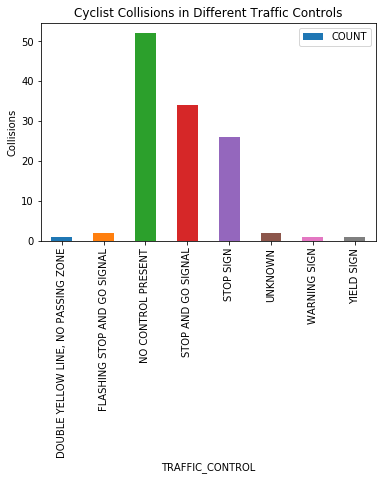

In [45]:
df3[df3.BIPED == 'B'].plot.bar(x='TRAFFIC_CONTROL', y='COUNT')
plt.title('Cyclist Collisions in Different Traffic Controls')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

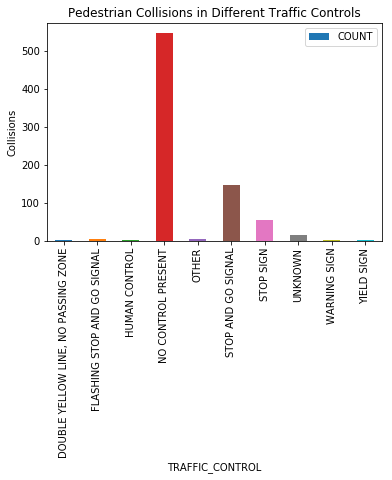

In [46]:
df3[df3.BIPED == 'P'].plot.bar(x='TRAFFIC_CONTROL', y='COUNT')
plt.title('Pedestrian Collisions in Different Traffic Controls')
plt.ylabel('Collisions')

Text(0,0.5,'Collisions')

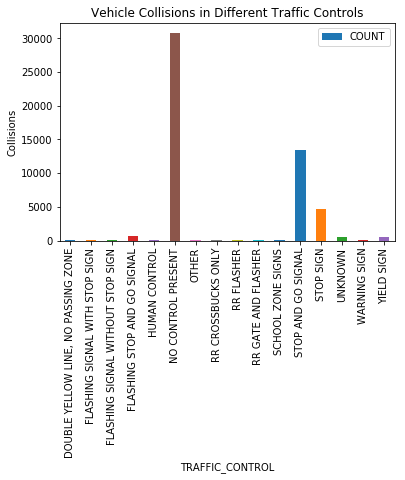

In [47]:
df3[df3.BIPED == 'M'].plot.bar(x='TRAFFIC_CONTROL', y='COUNT')
plt.title('Vehicle Collisions in Different Traffic Controls')
plt.ylabel('Collisions')

In [48]:
df31 = df3[df3['TRAFFIC_CONTROL'].isin(['DOUBLE YELLOW LINE, NO PASSING ZONE', 'FLASHING STOP AND GO SIGNAL', 
                                        'NO CONTROL PRESENT', 'STOP AND GO SIGNAL', 'STOP SIGN', 'UNKNOWN',
                                        'WARNING SIGN', 'YIELD SIGN'])]
df31_p = df31.pivot(index='BIPED', columns='TRAFFIC_CONTROL')
stats.chi2_contingency(df31_p)

(81.05262803125473,
 1.8041620457301413e-11,
 14,
 array([[2.27964937e-01, 1.51976625e+00, 7.21635674e+01, 3.12772499e+01,
         1.09722518e+01, 1.27568258e+00, 1.95727472e-01, 1.36778962e+00],
        [9.73007992e+01, 6.48671994e+02, 3.08011085e+04, 1.33498662e+04,
         4.68321523e+03, 5.44491341e+02, 8.35410902e+01, 5.83804795e+02],
        [1.47123590e+00, 9.80823932e+00, 4.65727897e+02, 2.01856537e+02,
         7.08125157e+01, 8.23297664e+00, 1.26318234e+00, 8.82741539e+00]]))

#### Distribution

In [49]:
all_data.OBJECTID.isnull().sum()

0

In [50]:
ds = all_data.groupby(['BIPED','DATE']).DATE.count().to_frame(name='COUNT').reset_index()
ds

     BIPED       DATE  COUNT
0        B 2014-01-20      1
1        B 2014-02-27      1
2        B 2014-05-06      1
3        B 2014-05-11      1
4        B 2014-05-31      1
5        B 2014-06-02      1
6        B 2014-06-10      1
7        B 2014-06-20      3
8        B 2014-06-22      1
9        B 2014-07-03      1
...    ...        ...    ...
2535     P 2018-11-27      1
2536     P 2018-11-28      2
2537     P 2018-11-30      2
2538     P 2018-12-01      1
2539     P 2018-12-02      3
2540     P 2018-12-03      1
2541     P 2018-12-05      1
2542     P 2018-12-13      1
2543     P 2018-12-27      1
2544     P 2018-12-29      1

[2545 rows x 3 columns]

In [51]:
ds_1 = ds.groupby(['BIPED','COUNT']).COUNT.count().to_frame(name='FREQ').reset_index()
ds_1

   BIPED  COUNT  FREQ
0      B      1   102
1      B      2     7
2      B      3     1
3      M      6     1
4      M      7     3
5      M      8     5
6      M      9     1
7      M     10     7
8      M     11    13
9      M     12    15
..   ...    ...   ...
63     M     77     1
64     M     82     1
65     M     87     1
66     M     88     1
67     M     91     1
68     M    116     1
69     P      1   473
70     P      2   108
71     P      3    27
72     P      4     1

[73 rows x 3 columns]

In [52]:
lamB = ds[ds.BIPED=='B'].COUNT.mean()
lamP = ds[ds.BIPED=='P'].COUNT.mean()
lamM = ds[ds.BIPED=='M'].COUNT.mean()

print('Distribution for no. of Vehicle collisions per day is: Poisson(',lamM,')')
print('Distribution for no. of Pedestrian collisions per day is: Poisson(',lamP,')')
print('Distribution for no. of Cyclist collisions per day is: Poisson(',lamB,')')

Distribution for no. of Vehicle collisions per day is: Poisson( 27.99069003285871 )
Distribution for no. of Pedestrian collisions per day is: Poisson( 1.270935960591133 )
Distribution for no. of Cyclist collisions per day is: Poisson( 1.0818181818181818 )


In [53]:
xP = ds_1[ds_1.BIPED=='P'].COUNT
xB = ds_1[ds_1.BIPED=='B'].COUNT
xM = ds_1[ds_1.BIPED=='M'].COUNT

In [54]:
totP = ds_1[ds_1.BIPED=='P'].FREQ.sum()
totM = ds_1[ds_1.BIPED=='M'].FREQ.sum()
totB = ds_1[ds_1.BIPED=='B'].FREQ.sum()

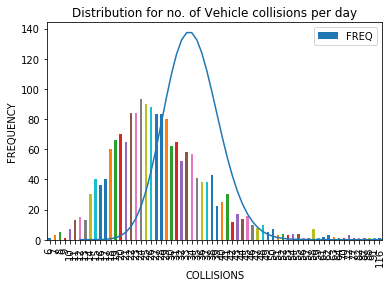

In [55]:
ds_1[ds_1.BIPED == 'M'].plot.bar(x='COUNT', y='FREQ')
plt.title('Distribution for no. of Vehicle collisions per day')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')
plt.plot(xM, poisson.pmf(xM, lamM)*(totM))

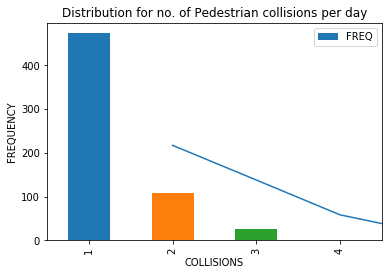

In [56]:
ds_1[ds_1.BIPED == 'P'].plot.bar(x='COUNT', y='FREQ')
plt.title('Distribution for no. of Pedestrian collisions per day')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')
plt.plot(xP, poisson.pmf(xP, lamP)*totP)

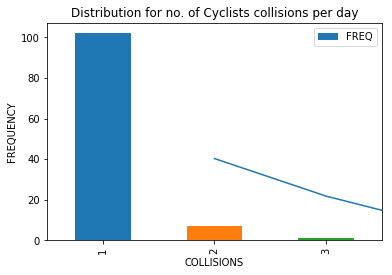

In [57]:
ds_1[ds_1.BIPED == 'B'].plot.bar(x='COUNT', y='FREQ')
plt.title('Distribution for no. of Cyclists collisions per day')
plt.ylabel('FREQUENCY')
plt.xlabel('COLLISIONS')
plt.plot(xB, poisson.pmf(xB, lamB)*totB)

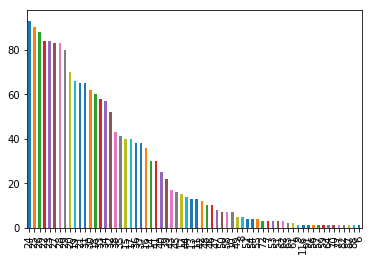

In [58]:
ds[ds.BIPED == 'M']['COUNT'].value_counts().plot(kind='bar')
#plt.show()
#ds['COUNT'].value_counts().plot(kind='bar')

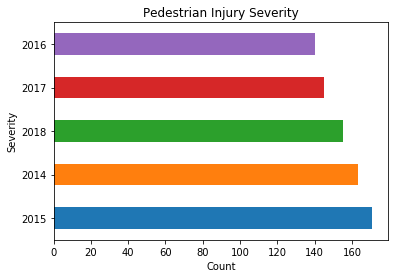

In [59]:
ped_data['YEAR'].value_counts().plot(kind='barh')
plt.title('Pedestrian Injury Severity')
plt.ylabel('Severity')
plt.xlabel('Count')
plt.show()

In [60]:
ped_data.ACCIDENT_YEAR.value_counts()

2015    171
2014    163
2018    155
2017    145
2016    140
Name: ACCIDENT_YEAR, dtype: int64

In [62]:
motor_data.ACCIDENT_YEAR.value_counts()

2018    11093
2017    10873
2016    10699
2015     9740
2014     8706
Name: ACCIDENT_YEAR, dtype: int64

In [63]:
ped_data.SEVERITY.value_counts()

C Type Injury (Possible)             435
B Type Injury (Evident)              173
B Type Injury (Suspected Minor)       55
A Type Injury (Disabling)             42
O No Injury                           18
A Type Injury (Suspected Serious)     16
Name: SEVERITY, dtype: int64

In [64]:
motor_data.SEVERITY.value_counts()

O No Injury                          31862
C Type Injury (Possible)             15786
B Type Injury (Evident)               1846
UNKNOWN                                799
B Type Injury (Suspected Minor)        610
A Type Injury (Disabling)               82
A Type Injury (Suspected Serious)       32
Name: SEVERITY, dtype: int64

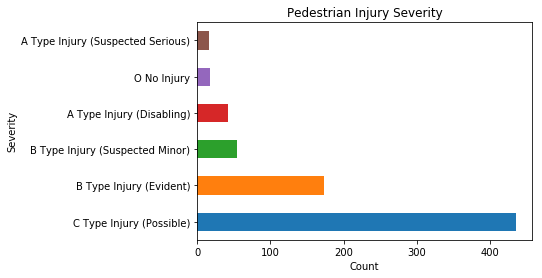

In [67]:
ped_data['SEVERITY'].value_counts().plot(kind='barh')
plt.title('Pedestrian Injury Severity')
plt.ylabel('Severity')
plt.xlabel('Count')
plt.show()

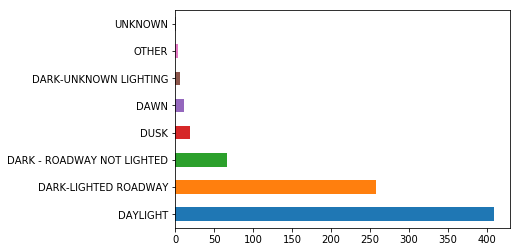

In [68]:
ped_data['LIGHT_CONDITIONS'].value_counts().plot(kind='barh')
plt.show()

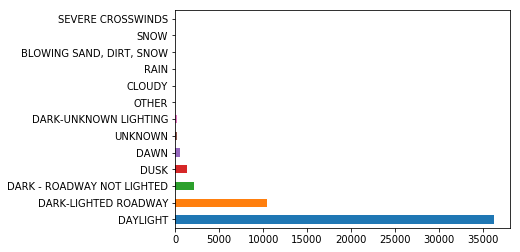

In [69]:
motor_data['LIGHT_CONDITIONS'].value_counts().plot(kind='barh')
plt.show()

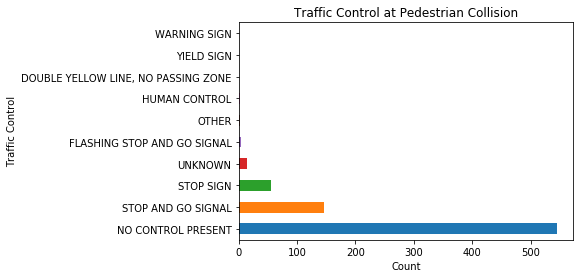

In [70]:
ped_data['TRAFFIC_CONTROL'].value_counts().plot(kind='barh')
plt.title('Traffic Control at Pedestrian Collision')
plt.ylabel('Traffic Control')
plt.xlabel('Count')
plt.show()

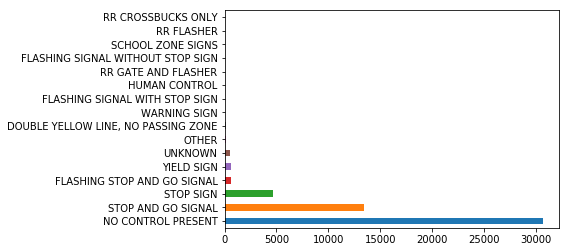

In [71]:
motor_data['TRAFFIC_CONTROL'].value_counts().plot(kind='barh')
plt.show()

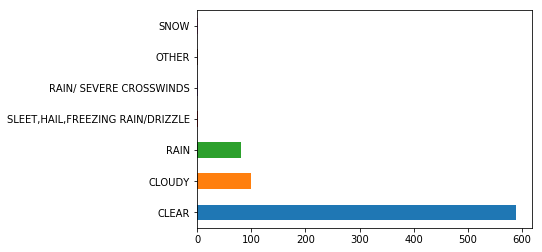

In [72]:
ped_data['WEATHER'].value_counts().plot(kind='barh')
plt.show()

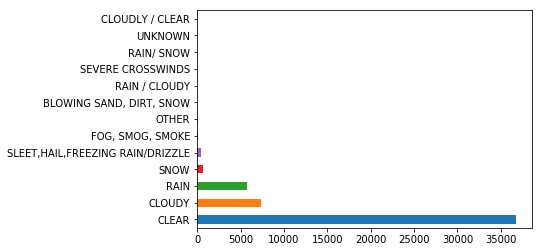

In [73]:
motor_data['WEATHER'].value_counts().plot(kind='barh')
plt.show()

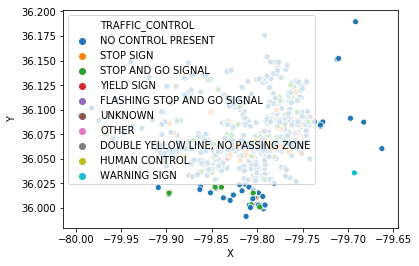

In [75]:
#sns.scatterplot(x="X", y="Y", hue="TRAFFIC_CONTROL", data=ped_data)
sns.scatterplot(x="X", y="Y", hue="TRAFFIC_CONTROL", data=ped_data)
plt.show()